# Credit Risk Resampling Techniques

In [1]:
#This will enable completion on elements of lists, results of function calls, etc
%config IPCompleter.greedy=True
#the output of plotting commands is displayed inline within frontends like the Jupyter notebook
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from matplotlib import rcParams

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Read the CSV and Perform Basic Data Cleaning for performing operations 

In [4]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [5]:
# Load the data from the device using path
file_path = Path('./data/raw/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]


# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

loan_amnt  int_rate  installment home_ownership  annual_inc  \
0    10500.0    0.1719       375.35           RENT     66000.0   
1    25000.0    0.2000       929.09       MORTGAGE    105000.0   
2    20000.0    0.2000       529.88       MORTGAGE     56000.0   
3    10000.0    0.1640       353.55           RENT     92000.0   
4    22000.0    0.1474       520.39       MORTGAGE     52000.0   

  verification_status   issue_d loan_status pymnt_plan    dti  ...  \
0     Source Verified  Mar-2019    low_risk          n  27.24  ...   
1            Verified  Mar-2019    low_risk          n  20.23  ...   
2            Verified  Mar-2019    low_risk          n  24.26  ...   
3            Verified  Mar-2019    low_risk          n  31.44  ...   
4        Not Verified  Mar-2019    low_risk          n  18.76  ...   

   pct_tl_nvr_dlq  percent_bc_gt_75  pub_rec_bankruptcies  tax_liens  \
0            85.7             100.0                   0.0        0.0   
1            91.2              50.0                   1.0        0.0   
2            66.7              50.0                   0.0        0.0   
3           100.0              50.0                   1.0        0.0   
4           100.0               0.0                   0.0        0.0   

   tot_hi_cred_lim  total_bal_ex_mort total_bc_limit  \
0          65687.0            38199.0         2000.0   
1         271427.0            60641.0        41200.0   
2          60644.0            45684.0         7500.0   
3          99506.0            68784.0        19700.0   
4         219750.0            25919.0        27600.0   

   total_il_high_credit_limit  hardship_flag  debt_settlement_flag  
0                     61987.0              N                     N  
1                     49197.0              N                     N  
2                     43144.0              N                     N  
3                     76506.0              N                     N  
4                     20000.0              N                     N  

[5 rows x 86 columns]

# Split the Data into Training and Testing

In [6]:
# Create our features
X_df = df.drop(columns=['loan_status'])
X = pd.get_dummies(X_df, columns=["home_ownership","verification_status","issue_d",
                                  "pymnt_plan","initial_list_status","next_pymnt_d","debt_settlement_flag",
                                  "application_type","hardship_flag"], drop_first = True)

# Create our target
y = df['loan_status'].to_frame()

In [7]:
X.describe()

loan_amnt      int_rate   installment    annual_inc           dti  \
count  68817.000000  68817.000000  68817.000000  6.881700e+04  68817.000000   
mean   16677.594562      0.127718    480.652863  8.821371e+04     21.778153   
std    10277.348590      0.048130    288.062432  1.155800e+05     20.199244   
min     1000.000000      0.060000     30.890000  4.000000e+01      0.000000   
25%     9000.000000      0.088100    265.730000  5.000000e+04     13.890000   
50%    15000.000000      0.118000    404.560000  7.300000e+04     19.760000   
75%    24000.000000      0.155700    648.100000  1.040000e+05     26.660000   
max    40000.000000      0.308400   1676.230000  8.797500e+06    999.000000   

        delinq_2yrs  inq_last_6mths      open_acc       pub_rec  \
count  68817.000000    68817.000000  68817.000000  68817.000000   
mean       0.217766        0.497697     12.587340      0.126030   
std        0.718367        0.758122      6.022869      0.336797   
min        0.000000        0.000000      2.000000      0.000000   
25%        0.000000        0.000000      8.000000      0.000000   
50%        0.000000        0.000000     11.000000      0.000000   
75%        0.000000        1.000000     16.000000      0.000000   
max       18.000000        5.000000     72.000000      4.000000   

           revol_bal  ...  home_ownership_MORTGAGE  home_ownership_OWN  \
count   68817.000000  ...             68817.000000        68817.000000   
mean    17604.142828  ...                 0.526309            0.106747   
std     21835.880400  ...                 0.499311            0.308793   
min         0.000000  ...                 0.000000            0.000000   
25%      6293.000000  ...                 0.000000            0.000000   
50%     12068.000000  ...                 1.000000            0.000000   
75%     21735.000000  ...                 1.000000            0.000000   
max    587191.000000  ...                 1.000000            1.000000   

       home_ownership_RENT  verification_status_Source Verified  \
count         68817.000000                         68817.000000   
mean              0.357659                             0.373992   
std               0.479314                             0.483865   
min               0.000000                             0.000000   
25%               0.000000                             0.000000   
50%               0.000000                             0.000000   
75%               1.000000                             1.000000   
max               1.000000                             1.000000   

       verification_status_Verified  issue_d_Jan-2019  issue_d_Mar-2019  \
count                  68817.000000      68817.000000      68817.000000   
mean                       0.148001          0.451066          0.177238   
std                        0.355104          0.497603          0.381873   
min                        0.000000          0.000000          0.000000   
25%                        0.000000          0.000000          0.000000   
50%                        0.000000          0.000000          0.000000   
75%                        0.000000          1.000000          0.000000   
max                        1.000000          1.000000          1.000000   

       initial_list_status_w  next_pymnt_d_May-2019  \
count           68817.000000           68817.000000   
mean                0.876121               0.616839   
std                 0.329446               0.486161   
min                 0.000000               0.000000   
25%                 1.000000               0.000000   
50%                 1.000000               1.000000   
75%                 1.000000               1.000000   
max                 1.000000               1.000000   

       application_type_Joint App  
count                68817.000000  
mean                     0.139660  
std                      0.346637  
min                      0.000000  
25%                      0.000000  
50%                      0.000000  

In [8]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

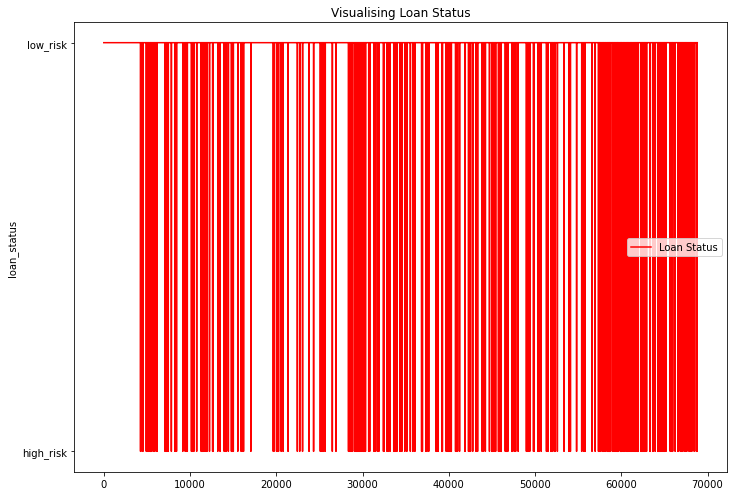

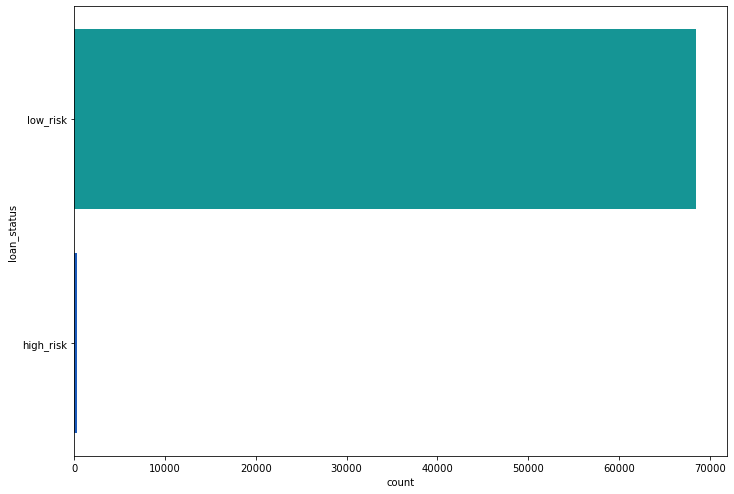

In [9]:
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

# Visualising the PM 2.5 Values

sns.lineplot(data = df["loan_status"], color="red", label="Loan Status")
plt.title('Visualising Loan Status')
plt.show()
sns.countplot(y = "loan_status", data = df, palette = 'winter_r')
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

# Oversampling
Imbalanced datasets are those where there is a severe skew in the class distribution, such as 1:100 or 1:1000 examples in the minority class to the majority class.

This bias in the training dataset can influence many machine learning algorithms, leading some to ignore the minority class entirely. This is a problem as it is typically the minority class on which predictions are most important.

One approach to addressing the problem of class imbalance is to randomly resample the training dataset. The two main approaches to randomly resampling an imbalanced dataset are to delete examples from the majority class, called undersampling, and to duplicate examples from the minority class, called oversampling.
In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling
The available samplers follows the scikit-learn API using the base estimator and adding a sampling functionality through the sample method
One way to fight this issue is to generate new samples in the classes which are under-represented. The most naive strategy is to generate new samples by randomly sampling with replacement the current available samples. The RandomOverSampler offers such scheme

In [11]:
# Resample the training data with the RandomOversampler and predicting high and low risk when oversampling is performed
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

y_resampled['loan_status'].value_counts()

low_risk     51352
high_risk    51352
Name: loan_status, dtype: int64

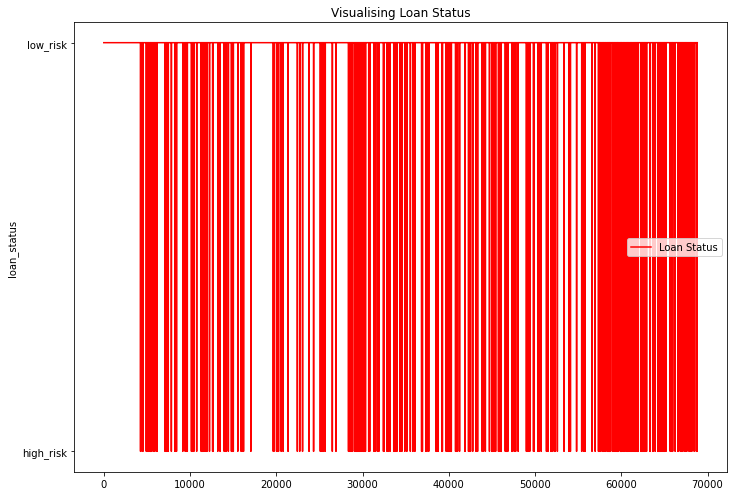

In [12]:
# figure size in 
#seaborn.lineplot(*, x=None, y=None, hue=None, size=None, style=None, data=None, palette=None, hue_order=None, hue_norm=None, sizes=None, size_order=None, size_norm=None, dashes=True, markers=None, style_order=None, units=None, estimator='mean', ci=95, n_boot=1000, seed=None, sort=True, err_style='band', err_kws=None, legend='auto', ax=None, **kwargs)¶
#Draw a line plot with possibility of several semantic groupings.

#The relationship between x and y can be shown for different subsets of the data using the hue, size, and style parameters. These parameters control what visual semantics are used to identify the different subsets. It is possible to show up to three dimensions independently by using all three semantic types, but this style of plot can be hard to interpret and is often ineffective. Using redundant semantics (i.e. both hue and style for the same variable) can be helpful for making graphics more accessible.
rcParams['figure.figsize'] = 11.7,8.27

# Visualising the PM 2.5 Values

sns.lineplot(data = df["loan_status"], color="red", label="Loan Status")
plt.title('Visualising Loan Status')
plt.show()

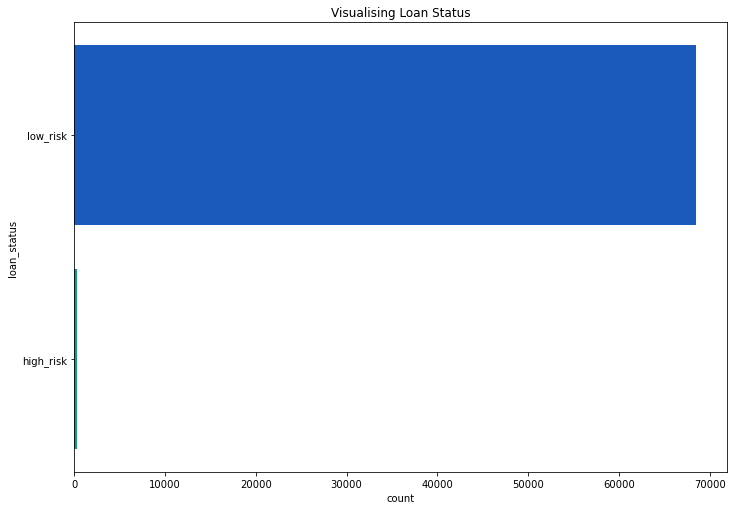

In [13]:
#seaborn.countplot(*, x=None, y=None, hue=None, data=None, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, dodge=True, ax=None, **kwargs)
#Show the counts of observations in each categorical bin using bars.

#A count plot can be thought of as a histogram across a categorical, instead of quantitative, variable. The basic API and options are identical to those for barplot(), so you can compare counts across nested variables.

rcParams['figure.figsize'] = 11.7,8.27
sns.countplot(y= "loan_status", data = df, palette='winter')
plt.title('Visualising Loan Status')
plt.show()

In [14]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [15]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score

y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6369308773583766

In [16]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[   54,    33],
       [ 5937, 11181]], dtype=int64)

In [17]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.62      0.65      0.02      0.64      0.40        87
   low_risk       1.00      0.65      0.62      0.79      0.64      0.41     17118

avg / total       0.99      0.65      0.62      0.79      0.64      0.41     17205



### SMOTE Oversampling
Imbalanced classification involves developing predictive models on classification datasets that have a severe class imbalance.

The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

In [18]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE(random_state=1, sampling_strategy=1.0).fit_resample(
    X_train, y_train
)
from collections import Counter

Counter(y_resampled)

Counter({'loan_status': 1})

In [19]:
# Train the Logistic Regression model using the resampled data
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [20]:
# Calculated the balanced accuracy score
y_pred = model.predict(X_test)
balanced_accuracy_score(y_test, y_pred)

0.6410271905757601

In [21]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[   53,    34],
       [ 5600, 11518]], dtype=int64)

In [22]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.61      0.67      0.02      0.64      0.41        87
   low_risk       1.00      0.67      0.61      0.80      0.64      0.41     17118

avg / total       0.99      0.67      0.61      0.80      0.64      0.41     17205

